
- 1 -> loading gtfs, laoding network (done)
- 2 -> defining pathways (done)
- 3 -> merging routes (done)
- 4 -> near stops (done)
- 5 -> routing
- 6 -> filtering
- 7 -> labeling

# Load network and gtfs

In [24]:
import osmnx as ox
import pandas as pd

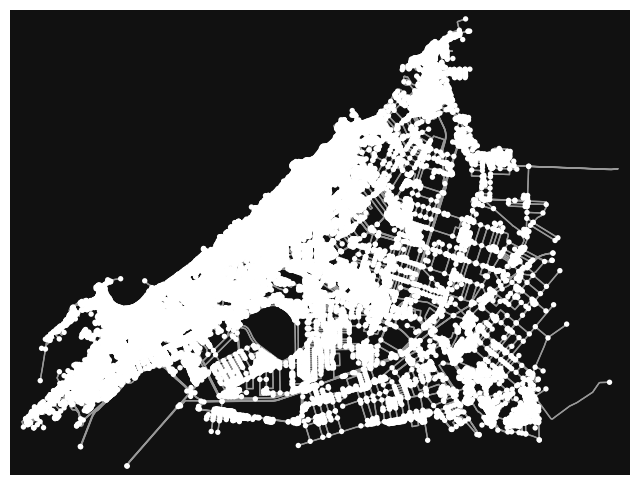

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [25]:
g = ox.graph_from_xml("labeled.osm", bidirectional=True, simplify=True)

ox.plot_graph(g)


In [26]:
# import gtfs files
path = "./gtfsAlex"
stops = pd.read_csv(path + "/stops.txt")
routes = pd.read_csv(path + "/routes.txt")
trips = pd.read_csv(path + "/trips.txt")
stop_times = pd.read_csv(path + "/stop_times.txt")
shapes = pd.read_csv(path + "/shapes.txt")

# construct pathways

In [27]:
pathways = pd.read_csv('trip_pathways.csv')

# merge trips to the network

In [28]:
import osmnx as ox
import pandas as pd

# 1. Build a mapping: stop_id -> list of trip_ids
stop_to_trips = (
    stop_times.groupby('stop_id')['trip_id']
    .apply(list) # Use list to be safe, though set is fine too
    .to_dict()
)

# 2. Map stops to nearest nodes (Vectorized - Keep this, it's good)
stop_nodes = ox.distance.nearest_nodes(
    g,
    X=stops['stop_lon'].values,
    Y=stops['stop_lat'].values
)
stop_to_node_map = pd.Series(stop_nodes, index=stops['stop_id']).to_dict()

# 3. Attach {trip_id: stop_id} to the OSM nodes
for stop_id, node_id in stop_to_node_map.items():
    trips_at_stop = stop_to_trips.get(stop_id)
    
    if trips_at_stop:
        # Initialize the map if it doesn't exist
        if 'boarding_map' not in g.nodes[node_id]:
            g.nodes[node_id]['boarding_map'] = {}
        
        # Map every trip at this stop to THIS specific stop_id
        # This handles cases where multiple stops (e.g., opposite sides of road)
        # map to the same OSM node.
        for trip_id in trips_at_stop:
            g.nodes[node_id]['boarding_map'][trip_id] = stop_id

print("Finished mapping trips to graph nodes with specific stop IDs.")

Finished mapping trips to graph nodes with specific stop IDs.


In [29]:
# Create a dictionary of nodes that have the new 'boarding_map' data attached
nodes_with_trips = {n: data for n, data in g.nodes(data=True) if 'boarding_map' in data}

# Print a count of how many nodes have trip information
print(f"{len(nodes_with_trips)} nodes have trips attached")

# Print the trips for the first 10 nodes as a sample
print("\n--- Sample of nodes and their associated boarding maps ---")
print("(Format: {Trip_ID: Actual_GTFS_Stop_ID})")

for node, data in list(nodes_with_trips.items())[:10]:
    boarding_data = data['boarding_map']
    
    # Optional: Print count of trips at this node for clarity
    print(f"Node {node} has {len(boarding_data)} trips:")
    print(f"  {boarding_data}")
    print("-" * 20)

284 nodes have trips attached

--- Sample of nodes and their associated boarding maps ---
(Format: {Trip_ID: Actual_GTFS_Stop_ID})
Node 81312379 has 7 trips:
  {'3CgzuUO_dn1teCfMyugyc-07:00:00': 227, '3JTmhQmnxSU9cPkJSaSlE-07:00:00': 227, 'GVMY3J8hLKwB3k_XzZZNA-07:00:00': 227, 'Hn0eoDFbdIiLk49QaqFeX-07:00:00': 227, 'iGgUl6NwJYqGWhVkUHdiu-07:00:00': 227, 'pCUExpIx94RHG6BGAhT6a-07:00:00': 227, 'zZjzzNbMESUGofW2jqGDZ-07:00:00': 227}
--------------------
Node 260754134 has 9 trips:
  {'3DsaT0dcW0e0BLcyD3Q6E-07:00:00': 182, 'bd7828viXdflnfuupm3s6-07:00:00': 182, 'E3cKTAI5hrMdq3gv0l-3g-07:00:00': 182, 'EoBxLx54RiTmwf0L64PXs-07:00:00': 182, 'J3ADe7YQWUaBHH8Z_00Ou-07:00:00': 182, 'LYcY_J8e-Dijvjm6uZhgZ-07:00:00': 182, 'R1qyf44TfvStHmjMCiKfC-07:00:00': 182, 'RmCIDxJQKwF7GOCKKX3Oh-07:00:00': 182, 'tObSXctDA10XZJ6oW1EYp-07:00:00': 182}
--------------------
Node 260758565 has 1 trips:
  {'divI9MoAnOSksgYUNogFE-07:00:00': 361}
--------------------
Node 260758678 has 9 trips:
  {'4dazyxD50LYtjM4jq9_

--- Node 261726784 Data ---
  y: 31.2066219
  x: 29.9059031

  [boarding_map] Connected Trips: 40
  Sample (Trip ID -> GTFS Stop ID):
    _xaRNY3_AfOnhpf5yTE3A-07:00:00: 198
    40rOFL2qzN26P2ty7q_b9-07:00:00: 198
    9ByH2YQ54cshi1Sj8kgPQ-07:00:00: 198
    bAHUtWeGgy-NzZiHpbdim-07:00:00: 198
    Cl-oT7WLLDtvd9UF3t3WF-07:00:00: 198
    ... (+ 35 more)


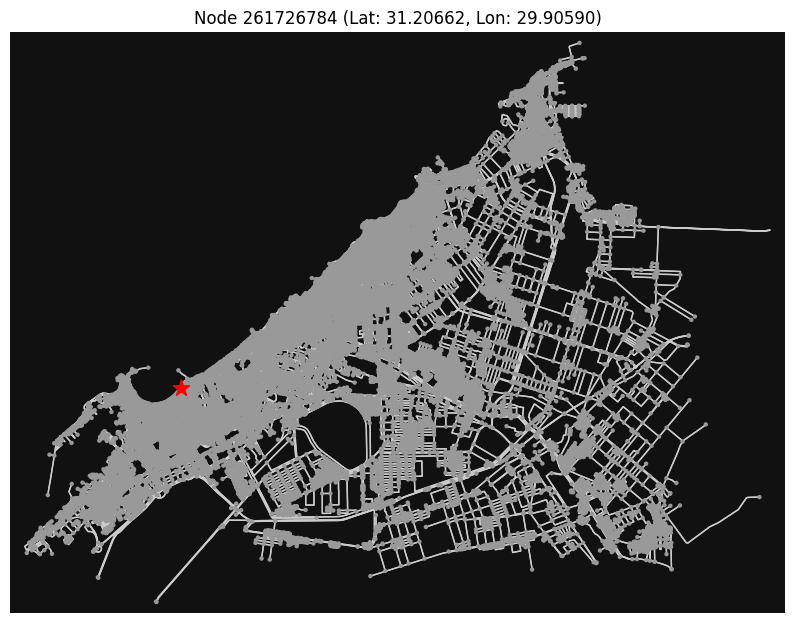

In [30]:
import matplotlib.pyplot as plt
import osmnx as ox

node_id = 261726784

if node_id in g.nodes:
    data = g.nodes[node_id]
    print(f"--- Node {node_id} Data ---")
    
    # 1. Print basic attributes (x, y, osmid, etc.)
    for key, value in data.items():
        if key == 'boarding_map': 
            continue  # Skip the big dictionary for now
        print(f"  {key}: {value}")
    
    # 2. Print specific Boarding Map info (The new structure)
    if 'boarding_map' in data:
        b_map = data['boarding_map']
        print(f"\n  [boarding_map] Connected Trips: {len(b_map)}")
        print(f"  Sample (Trip ID -> GTFS Stop ID):")
        
        # Print only first 5 for readability
        for i, (trip_id, stop_id) in enumerate(b_map.items()):
            if i >= 5:
                print(f"    ... (+ {len(b_map)-5} more)")
                break
            print(f"    {trip_id}: {stop_id}")
    else:
        print("\n  [boarding_map] No trips attached to this node.")

    # 3. Visualize location
    # Use a small bounding box or just plot the whole graph (warning: whole graph might be slow)
    # If the graph is huge, it's better to plot a subgraph, but here is the direct update:
    fig, ax = ox.plot_graph(
        g, 
        node_color="#999999", 
        node_size=10, 
        edge_color="#cccccc",
        show=False, 
        close=False,
        figsize=(10, 10)
    )
    
    x = data['x']
    y = data['y']
    
    # Highlight the specific node in RED
    ax.scatter(x, y, c="red", s=150, zorder=10, marker='*')
    ax.set_title(f"Node {node_id} (Lat: {y:.5f}, Lon: {x:.5f})")
    
    plt.show()

else:
    print(f"Node {node_id} not found in graph.")

# Find reachable routes from start and end points

In [31]:
import heapq

def explore_trips(G, source, cutoff=float("inf")):
    """
    Returns:
        dict of trip_id -> {
            'stop_id': gtfs_stop_id, # The actual GTFS ID needed for costs
            'osm_node_id': osm_node,       # The physical location
            'walk': distance_m,
            'path': [...]
        }
    """
    dist = {source: 0.0}
    prev = {}
    pq = [(0.0, source)]
    visited = set()

    trips = {}

    def reconstruct_path(node):
        path = []
        while node in prev:
            path.append(node)
            node = prev[node]
        path.append(source)
        return list(reversed(path))

    while pq:
        d, node = heapq.heappop(pq)

        if d > cutoff:
            break
        if node in visited:
            continue
        visited.add(node)

        # [CHANGE]: Retrieve the boarding_map instead of just a list of trips
        boarding_map = G.nodes[node].get("boarding_map")
        
        if boarding_map:
            # Iterate over the trips available at this node
            for trip_id, real_stop_id in boarding_map.items():
                
                # Check if this is the best walk to this trip so far
                best = trips.get(trip_id)
                if best is None or d < best["walk"]:
                    trips[trip_id] = {
                        "stop_id": real_stop_id, # SAVE THE GTFS STOP ID
                        "osm_node_id": node,        # Save OSM ID just in case
                        "walk": d,
                        "path": reconstruct_path(node)
                    }

        # Relax neighbors (Standard Dijkstra)
        for nbr, edge_data in G[node].items():
            for _, attr in edge_data.items():
                length = float(attr.get("length", 1.0))
                new_dist = d + length

                if new_dist <= cutoff and new_dist < dist.get(nbr, float("inf")):
                    dist[nbr] = new_dist
                    prev[nbr] = node
                    heapq.heappush(pq, (new_dist, nbr))

    return trips

In [32]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import random

def display_trips_on_map(G, trips, start_node=None):
    """
    Visualize reachable trips and their walking paths on a folium map.
    Compatible with new explore_trips() structure.
    """
    # Initialize map centered on start node
    if start_node is not None:
        start_lat, start_lon = G.nodes[start_node]['y'], G.nodes[start_node]['x']
    else:
        first_node = list(G.nodes)[0]
        start_lat, start_lon = G.nodes[first_node]['y'], G.nodes[first_node]['x']

    m = folium.Map(location=[start_lat, start_lon], zoom_start=15)

    # Colormap
    colormap = cm.get_cmap("tab20", len(trips))
    colors_list = [colors.rgb2hex(colormap(i)) for i in range(len(trips))]

    # Draw each trip path
    for i, (trip_id, data) in enumerate(trips.items()):
        path = data["path"]
        dist = data["walk"]
        node = data["osm_node_id"]

        # Convert node IDs to coordinates
        coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path if n in G.nodes]

        # Draw walking path
        folium.PolyLine(
            coords,
            color=colors_list[i % len(colors_list)],
            weight=4,
            opacity=0.8,
            tooltip=f"Trip: {trip_id}<br>Distance: {dist:.1f} m"
        ).add_to(m)

        # Mark access node
        folium.CircleMarker(
            location=(G.nodes[node]['y'], G.nodes[node]['x']),
            radius=5,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.9,
            tooltip=f"Access Node: {node}"
        ).add_to(m)

    # Mark the source node
    if start_node is not None:
        folium.CircleMarker(
            location=(G.nodes[start_node]['y'], G.nodes[start_node]['x']),
            radius=6,
            color="blue",
            fill=True,
            fill_color="blue",
            tooltip="Start Node"
        ).add_to(m)

    return m

In [33]:
# --- 1. Define the starting point and find the nearest node ---
lon, lat = 29.96139328537071, 31.22968895248673
source_node = ox.distance.nearest_nodes(g, X=lon, Y=lat)

trip_to_route = trips.set_index('trip_id')['route_id'].to_dict()
route_id_to_name = routes.set_index('route_id')['route_long_name'].to_dict()

print(f"Starting trip exploration from node {source_node}...")

# --- 2. Find all reachable trips within a 1000m walking distance ---
start_trips = explore_trips(g, source_node, cutoff=1000)

# --- 3. Print the results ---
print("\n--- Results ---")
if start_trips:
    print(f"Found {len(start_trips)} reachable trips within 1km:")

    for trip_id, data in start_trips.items():
        route_id = trip_to_route.get(trip_id)
        route_name = route_id_to_name.get(route_id, "Unknown Route")
        walk_dist = data['walk']
        start_stop = data['stop_id']
        path = data['path']

        print(f"\n- Trip '{trip_id}'")
        print(f"  Route: '{route_name}'")
        print(f"  Access node: {start_stop}")
        print(f"  Walking distance: {walk_dist:.1f} meters")
        print(f"  Walking path (nodes): {path}")
else:
    print("No reachable trips found within 1km.")

# --- 4. Display all discovered paths on a single map ---
if start_trips:
    trip_map = display_trips_on_map(g, start_trips, start_node=source_node)
    display(trip_map)


Starting trip exploration from node 4166047227...

--- Results ---
Found 5 reachable trips within 1km:

- Trip 'tL1NRyqKwJOCmUECmIQqO-07:00:00'
  Route: 'El-Sa'ah (Clock Square) - Sidi Gabir'
  Access node: 439
  Walking distance: 497.7 meters
  Walking path (nodes): [4166047227, 1886562849, 6977064734, 6977079033, 6977079054, 6987704483, 7006574878, 6977079053, 339078213, 339078215, 3969615351]

- Trip 'FUo5FExiKwUTpyTUJYA7R-07:00:00'
  Route: 'Asafra - Train Station (El-Shohada Square)'
  Access node: 291
  Walking distance: 653.2 meters
  Walking path (nodes): [4166047227, 1886562849, 6977064720, 6977064719, 4166054337, 1886562895, 6986740396, 6977079022, 4166048754, 1886562842, 6346410642, 339078211, 4709690776, 5064688375, 7257436116]

- Trip 'oL-cc2-4cc5VXM7r-ShUc-07:00:00'
  Route: 'Street 45 - Train Station (El-Shohada Square)'
  Access node: 291
  Walking distance: 653.2 meters
  Walking path (nodes): [4166047227, 1886562849, 6977064720, 6977064719, 4166054337, 1886562895, 698

/tmp/ipykernel_52244/2030117243.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab20", len(trips))


In [34]:
# --- 1. Define the starting point and find the nearest node ---
lon, lat = 29.94194179397711, 31.20775934404925
source_node = ox.distance.nearest_nodes(g, X=lon, Y=lat)
print(f"Starting trip exploration from node {source_node}...")

# --- 2. Find all reachable trips within a 1600m walking distance ---
target_trips = explore_trips(g, source_node, cutoff=1000)

# --- 3. Print the results ---
print("\n--- Results ---")
if target_trips:
    print(f"Found {len(target_trips)} reachable trips within 1.6 km:")
    for trip_id, data in target_trips.items():
        dist = data["walk"]
        node = data["osm_node_id"]
        path = data["path"]

        # Look up the route name using your mapping dictionaries
        route_id = trip_to_route.get(trip_id)
        route_name = route_id_to_name.get(route_id, "Unknown Route")

        print(f"- Route '{route_name}' (Trip: {trip_id}) found at node {node} ({dist:.1f} m away)")
else:
    print("No reachable trips found within 1.6 km.")

# --- 4. Display all discovered paths on a single map ---
if target_trips:
    trip_map = display_trips_on_map(g, target_trips, start_node=source_node)
    display(trip_map)

Starting trip exploration from node 8432185075...

--- Results ---
Found 19 reachable trips within 1.6 km:
- Route 'Ezbet Saad - Sidi Gabir' (Trip: TWnfYDX6BkJirORXmg2hv-07:00:00) found at node 6942587478 (145.6 m away)
- Route 'El-Mansheya - Ezbet Saad' (Trip: gqntW1mb4ahLW_IHlR39R-07:00:00) found at node 265746703 (199.9 m away)
- Route 'El-Mansheya - Ezbet Saad' (Trip: EglZxh1NkJA5Jax303ARy-07:00:00) found at node 6942587547 (226.8 m away)
- Route 'El-Mansheya - Green Plaza Mall' (Trip: rz-CFcB9J3xy60VYWjZAn-07:00:00) found at node 6942587547 (226.8 m away)
- Route 'El-Mansheya - Hagar Al-Nawateyah (Namos Bridge)' (Trip: _npHlyCCY7o0R20RyqvT8-07:00:00) found at node 6944660397 (640.4 m away)
- Route 'El-Mansheya - Smouha' (Trip: gp93eQ2WYNnUOJrA17bFP-07:00:00) found at node 6944660397 (640.4 m away)
- Route 'Abo Soliman - El-Mansheya' (Trip: PAh8O-96IhPU2mfK1XGjm-07:00:00) found at node 6944660397 (640.4 m away)
- Route 'Ezbet Saad - Sidi Gabir' (Trip: aL3IoFC8Ob46ci80-r5J_-07:00:00

/tmp/ipykernel_52244/2030117243.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("tab20", len(trips))


# Routing

In [35]:
from collections import defaultdict
trip_graph = defaultdict(dict)
pathways_dict = pathways.to_dict('index')

for idx, row in pathways.iterrows():
    trip_graph[row['start_trip_id']][row['end_trip_id']] = idx 

print(f"Graph built with {len(trip_graph)} unique starting trips and {sum(len(v) for v in trip_graph.values())} edges.")

Graph built with 191 unique starting trips and 5150 edges.


In [36]:
import pandas as pd

def get_distance(trip_id, start_stop, end_stop):
    # query db here, for now return total distance from trip_distances.csv
    dist = pd.read_csv("utils/trip_distances.csv")
    return dist[dist["trip_id"] == trip_id]["distance_km"].values[0]


get_distance("TWnfYDX6BkJirORXmg2hv-07:00:00", "start_stop", "end_stop")

1.2766

In [37]:
import numpy as np
from joblib import load
from sklearn.base import BaseEstimator, RegressorMixin

class TripPricePredictor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def _round_bus_style(self, vals):
        """Your custom rounding logic embedded in the class"""
        scalar = np.isscalar(vals)
        arr = np.array([vals]) if scalar else np.asarray(vals)
        out = []
        for v in arr:
            pounds = int(np.floor(v))
            dec = v - pounds
            if dec < 0.125: r = pounds + 0.0
            elif dec < 0.375: r = pounds + 0.25
            elif dec < 0.75: r = pounds + 0.5
            else: r = pounds + 1.0
            out.append(round(r, 2))
        return out[0] if scalar else np.array(out)

    def predict(self, distance_km):
        # 1. Preprocessing: Convert KM to Log Distance
        X = np.array(distance_km)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        X_log = np.log1p(X)

        # 2. Prediction
        raw_pred = self.model.predict(X_log)

        # 3. Post-processing: Custom Rounding
        return self._round_bus_style(raw_pred)

def load_model():
    model = load('utils/trip_price_model.joblib')
    return TripPricePredictor(model)



In [38]:
def get_cost(trip_id, start_stop, end_stop):
    distance = get_distance(trip_id, start_stop, end_stop)
    model = load_model()
    return model.predict([distance])[0]

get_cost("TWnfYDX6BkJirORXmg2hv-07:00:00", "", "")

/home/marwan/miniconda3/envs/aienv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


2.0

In [39]:
import json
def load_traffic():
    with open('prefixtimes.json', 'r') as file:
        prefix_times = json.load(file)
    return prefix_times

traffic = load_traffic()

def get_transport_time(trip_id, start_stop, end_stop):
    """
    Return travel time (seconds/minutes as stored) between two stops for a trip.
    """
    start = str(start_stop)
    end = str(end_stop)
    if trip_id not in traffic:
        raise KeyError(f"trip_id not found in traffic: '{trip_id}'")
    trip_times = traffic[trip_id]
    if start not in trip_times:
        raise KeyError(f"start_stop not found for trip '{trip_id}': '{start}'")
    if end not in trip_times:
        raise KeyError(f"end_stop not found for trip '{trip_id}': '{end}'")

    start_val = trip_times[start]
    end_val = trip_times[end]
    try:
        start_num = float(start_val)
    except Exception as e:
        raise ValueError(f"start_stop value is not numeric for trip '{trip_id}': start='{start}', value={start_val!r}") from e
    try:
        end_num = float(end_val)
    except Exception as e:
        raise ValueError(f"end_stop value is not numeric for trip '{trip_id}': end='{end}', value={end_val!r}") from e

    return end_num - start_num

get_transport_time("tXwMswYEHusmu2vLfRPR2-07:00:00", "220", "241")


# we might do a version with coordinates later


460.0

In [40]:
from collections import deque, defaultdict

def find_journeys(graph, pathways_dict, start_trips, goal_trips, max_transfers):
    results = []
    # (current_trip_id, current_board_stop_id, path_list, cumulative_costs)
    queue = deque()
    
    # Pruning dictionary
    best_costs_to_node = defaultdict(lambda: {
        'money': float('inf'),
        'transport_time': float('inf'),
        'walk': float('inf')
    })

    # --- 1. Initialize Start Trips ---
    for start_trip_id, data in start_trips.items():
        costs = {
            'money': 0,
            'transport_time': 0,
            'walk': data['walk']
        }
        path = [start_trip_id]
        start_stop = data['stop_id']
        
        queue.append((start_trip_id, start_stop, path, costs))
        best_costs_to_node[start_trip_id] = costs.copy()

        # Check 0-transfer goal
        if start_trip_id in goal_trips:
            goal_stop = goal_trips[start_trip_id]['stop_id']
            
            leg_money = get_cost(start_trip_id, start_stop, goal_stop)
            leg_time = get_transport_time(start_trip_id, start_stop, goal_stop)
            
            final_costs = costs.copy()
            final_costs['money'] += leg_money
            final_costs['transport_time'] += leg_time
            final_costs['walk'] += goal_trips[start_trip_id]['walk']
            
            results.append((path, final_costs))

    # --- 2. BFS ---
    while queue:
        (current_trip, current_board_stop, path, current_costs) = queue.popleft()
        
        if len(path) - 1 >= max_transfers:
            continue

        for next_trip, pathway_id in graph.get(current_trip, {}).items():
            pathway = pathways_dict[pathway_id]
            
            if next_trip in path: continue

            # --- Cost Logic ---
            # 1. Transfer Walk
            transfer_walk_cost = pathway['walking_distance_m']
            
            # 2. Cost of the PREVIOUS trip segment (from board_stop to transfer_stop)
            # We are getting off current_trip at pathway['start_stop_id']
            prev_trip_money = get_cost(
                current_trip, 
                current_board_stop, 
                pathway['start_stop_id']
            )
            prev_trip_time = get_transport_time(
                current_trip, 
                current_board_stop, 
                pathway['start_stop_id']
            )

            new_costs = {
                'money': current_costs['money'] + prev_trip_money,
                'transport_time': current_costs['transport_time'] + prev_trip_time,
                'walk': current_costs['walk'] + transfer_walk_cost
            }

            # --- Pruning---
            best_known = best_costs_to_node[next_trip]
            # if we are better in ANY metric, we explore
            is_potentially_useful = (
                new_costs['money'] < best_known['money'] or
                new_costs['transport_time'] < best_known['transport_time'] or
                new_costs['walk'] < best_known['walk']
            )

            if is_potentially_useful:
                # Update best knowns
                best_costs_to_node[next_trip]['money'] = min(best_known['money'], new_costs['money'])
                best_costs_to_node[next_trip]['transport_time'] = min(best_known['transport_time'], new_costs['transport_time'])
                best_costs_to_node[next_trip]['walk'] = min(best_known['walk'], new_costs['walk'])

                new_path = path + [next_trip]
                
                # We board the NEXT trip at pathway['end_stop_id']
                queue.append((next_trip, pathway['end_stop_id'], new_path, new_costs))

                # --- 3. Check Goal ---
                if next_trip in goal_trips:
                    goal_stop = goal_trips[next_trip]['stop_id']
                    
                    # FINAL leg cost (from transfer-in to goal-stop)
                    last_leg_money = get_cost(next_trip, pathway['end_stop_id'], goal_stop)
                    last_leg_time = get_transport_time(next_trip, pathway['end_stop_id'], goal_stop)
                    
                    final_journey_costs = new_costs.copy()
                    final_journey_costs['money'] += last_leg_money
                    final_journey_costs['transport_time'] += last_leg_time
                    final_journey_costs['walk'] += goal_trips[next_trip]['walk']
                    
                    results.append((new_path, final_journey_costs))

    return results

In [41]:
# --- 1. Define the starting point and find the nearest node ---
lon, lat = 29.96139328537071, 31.22968895248673
source_node = ox.distance.nearest_nodes(g, X=lon, Y=lat)

start_trips = explore_trips(g, source_node, cutoff=1000)

lon, lat = 29.94194179397711, 31.20775934404925
source_node = ox.distance.nearest_nodes(g, X=lon, Y=lat)
target_trips = explore_trips(g, source_node, cutoff=1000)

# save start_trips and target_trips to json files
import json
with open('start_trips.json', 'w') as f:
    json.dump(start_trips, f)
with open('target_trips.json', 'w') as f:
    json.dump(target_trips, f)


journeys = find_journeys(
    trip_graph,
    pathways_dict,
    start_trips,
    target_trips, 
    2)

print(f"Found {len(journeys)} journeys from start to goal trips.")
for path, costs in journeys:
    print(f"Journey via trips {path} with costs: {costs}")


/home/marwan/miniconda3/envs/aienv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/marwan/miniconda3/envs/aienv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/marwan/miniconda3/envs/aienv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using versio

Found 52 journeys from start to goal trips.
Journey via trips ['FUo5FExiKwUTpyTUJYA7R-07:00:00', 'APpubImR-DQ7ipx8VqTDi-07:00:00'] with costs: {'money': 7.5, 'transport_time': 704.0, 'walk': 2457.545770895136}
Journey via trips ['FUo5FExiKwUTpyTUJYA7R-07:00:00', 'QyDZF4yDNAntbYpYmjfxj-07:00:00'] with costs: {'money': 8.5, 'transport_time': 693.0, 'walk': 2457.545770895136}
Journey via trips ['FUo5FExiKwUTpyTUJYA7R-07:00:00', 'ZBtB-FXg8HG9MZ8swYNuQ-07:00:00'] with costs: {'money': 8.5, 'transport_time': 696.0, 'walk': 2457.545770895136}
Journey via trips ['FUo5FExiKwUTpyTUJYA7R-07:00:00', 'aL3IoFC8Ob46ci80-r5J_-07:00:00'] with costs: {'money': 6.0, 'transport_time': 695.0, 'walk': 2457.545770895136}
Journey via trips ['oL-cc2-4cc5VXM7r-ShUc-07:00:00', 'APpubImR-DQ7ipx8VqTDi-07:00:00'] with costs: {'money': 7.5, 'transport_time': 690.0, 'walk': 2457.545770895136}
Journey via trips ['oL-cc2-4cc5VXM7r-ShUc-07:00:00', 'QyDZF4yDNAntbYpYmjfxj-07:00:00'] with costs: {'money': 8.5, 'transport_t

/home/marwan/miniconda3/envs/aienv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/marwan/miniconda3/envs/aienv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/marwan/miniconda3/envs/aienv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.6.1 when using versio

In [42]:

pathways[pathways['start_trip_id'] == 'oL-cc2-4cc5VXM7r-ShUc-07:00:00'].count()

start_trip_id         40
end_trip_id           40
start_route_id        40
end_route_id          40
start_stop_id         40
end_stop_id           40
walking_distance_m    40
walking_path_nodes    40
dtype: int64